# X5 NER Pipeline

Этот ноутбук содержит минимальный каркас для работы с задачей NER (TYPE, BRAND, VOLUME, PERCENT) и подготовки модели/сервиса.

- Блоки: Setup, Config, Data Loading, Preview
- Позже можно расширить: Tokenization, Training, Inference, Post-processing, Export


In [1]:
# Setup
import sys, os, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print('Python:', sys.version.split()[0])
print('Pandas:', pd.__version__)


Python: 3.9.6
Pandas: 2.3.2


In [ ]:
# Config
DATA_DIR = '/Users/marina/Documents/projects/X5/Датасет 2'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'submission.csv')
CSV_SEP = ';'

LABELS = ['O','B-TYPE','I-TYPE','B-BRAND','I-BRAND','B-VOLUME','I-VOLUME','B-PERCENT','I-PERCENT']
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}

print('Train:', TRAIN_PATH)
print('Test :', TEST_PATH)


Train: /Users/marina/Documents/projects/X5/Датасет 2/train.csv
Test : /Users/marina/Documents/projects/X5/Датасет 2/submission.csv


In [3]:
# Data Loading
train_df = pd.read_csv(TRAIN_PATH, sep=CSV_SEP)
print('Train shape:', train_df.shape)
print(train_df.head())

try:
    test_df = pd.read_csv(TEST_PATH, sep=CSV_SEP)
    print('Test shape:', test_df.shape)
except Exception as e:
    print('No test file yet or failed to read:', e)


Train shape: (27251, 2)
   sample           annotation
0      aa        [(0, 2, 'O')]
1    aala        [(0, 4, 'O')]
2  aarcca        [(0, 6, 'O')]
3    abon        [(0, 4, 'O')]
4    abso  [(0, 4, 'B-BRAND')]
Test shape: (5000, 2)


## 4. Schema & Samples
Purpose: verify required columns, parse annotations, and preview examples.
- Checks presence of `sample` and `annotation` columns.
- Parses BIO annotations from string to Python list of (start, end, tag).
- Prints a few examples: text + parsed entities.
- Lists unique entity tag types found (TYPE, BRAND, VOLUME, PERCENT).


In [4]:
# Validate columns
required_cols = {'sample','annotation'}
missing = required_cols - set(train_df.columns)
assert not missing, f"Missing columns: {missing}"

# Parse annotations
import ast

def parse_annotation(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

train_df['parsed_annotation'] = train_df['annotation'].apply(parse_annotation)

# Collect unique entity types
entity_types = set()
for ann in train_df['parsed_annotation']:
    for _, _, tag in ann:
        if tag != 'O' and '-' in tag:
            entity_types.add(tag.split('-',1)[1])

print('Unique entity types:', sorted(entity_types))

# Show samples
for i in range(3):
    row = train_df.iloc[i]
    print('\n---')
    print('Text:', row['sample'])
    print('Ann :', row['parsed_annotation'])


Unique entity types: ['BRAND', 'PERCENT', 'TYPE', 'VOLUME']

---
Text: aa
Ann : [(0, 2, 'O')]

---
Text: aala
Ann : [(0, 4, 'O')]

---
Text: aarcca
Ann : [(0, 6, 'O')]


## 5. EDA — Lengths & Entity Distributions
Purpose: understand typical query lengths and label imbalance.
- Compute distributions for characters and words per query.
- Count entities per class (TYPE, BRAND, VOLUME, PERCENT).
- These insights guide max sequence length, class weighting, and model focus.


Mean char length: 10.36761953689773
Mean word count : 1.5505119078198966


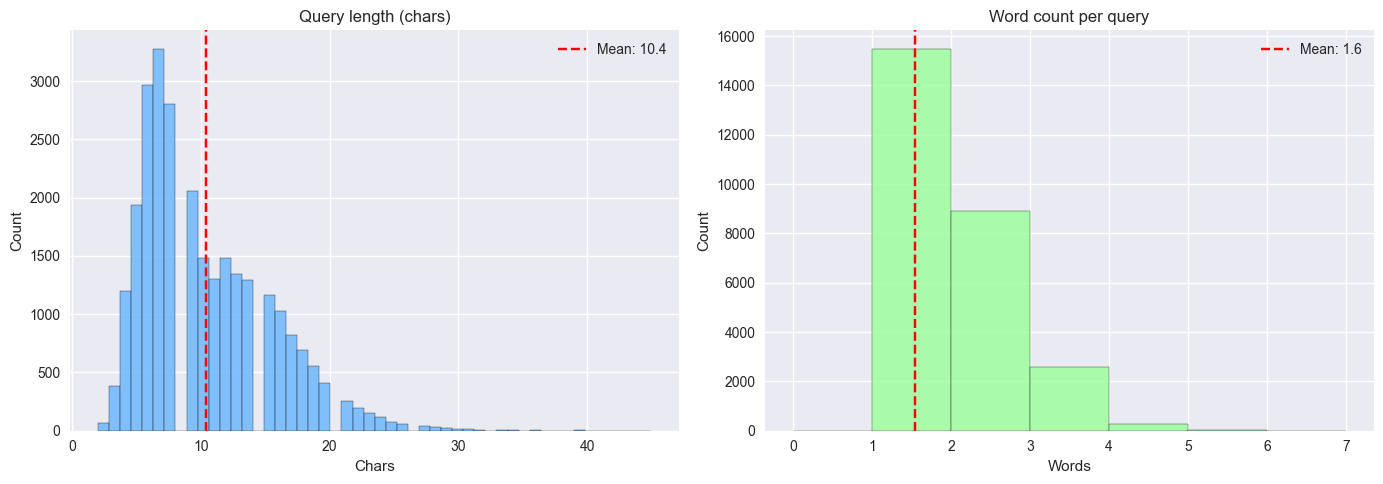

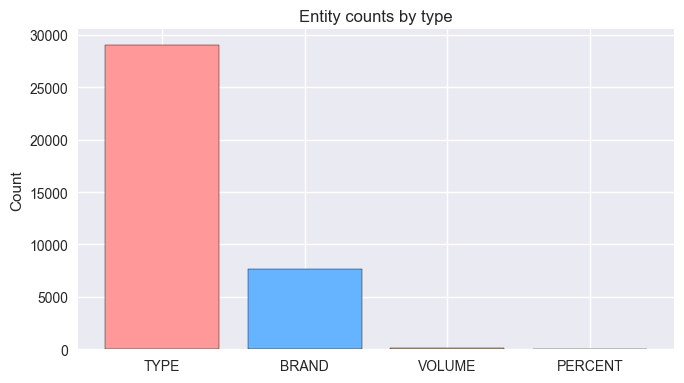

Per-query shares:
  TYPE: 89.90%
  BRAND: 26.47%
  VOLUME: 0.21%
  PERCENT: 0.10%


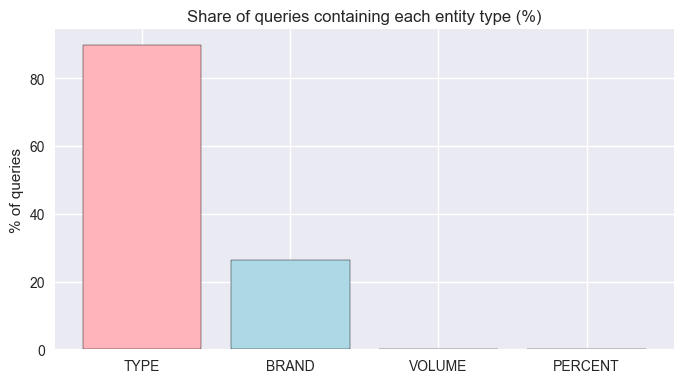

In [5]:
# Lengths
df = train_df.copy()
df['char_len'] = df['sample'].astype(str).str.len()
df['word_count'] = df['sample'].astype(str).str.split().apply(len)

print('Mean char length:', df['char_len'].mean())
print('Mean word count :', df['word_count'].mean())

fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].hist(df['char_len'], bins=50, color='#66b3ff', edgecolor='black', alpha=0.8)
axes[0].set_title('Query length (chars)')
axes[0].set_xlabel('Chars')
axes[0].set_ylabel('Count')
axes[0].axvline(df['char_len'].mean(), color='red', linestyle='--', label=f"Mean: {df['char_len'].mean():.1f}")
axes[0].legend()

axes[1].hist(df['word_count'], bins=range(0, df['word_count'].max()+2), color='#99ff99', edgecolor='black', alpha=0.8)
axes[1].set_title('Word count per query')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['word_count'].mean():.1f}")
axes[1].legend()
plt.tight_layout()
plt.show()

# Entity distributions
from collections import Counter
all_types = []
for ann in train_df['parsed_annotation']:
    for _, _, tag in ann:
        if tag != 'O' and '-' in tag:
            all_types.append(tag.split('-',1)[1])
cnt = Counter(all_types)
labels = ['TYPE','BRAND','VOLUME','PERCENT']
values = [cnt.get(l,0) for l in labels]
plt.figure(figsize=(7,4))
plt.bar(labels, values, color=['#ff9999','#66b3ff','#ffcc99','#c2c2f0'], edgecolor='black')
plt.title('Entity counts by type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Per-query shares: fraction of queries containing each entity type
def has_type(ann, t):
    return any((tag != 'O' and '-' in tag and tag.split('-',1)[1] == t) for _,_,tag in ann)

share = {}
N = len(train_df)
for t in labels:
    hits = sum(1 for ann in train_df['parsed_annotation'] if has_type(ann, t))
    share[t] = hits / N if N else 0.0

print('Per-query shares:')
for t in labels:
    print(f"  {t}: {share[t]*100:.2f}%")

plt.figure(figsize=(7,4))
plt.bar(labels, [share[t]*100 for t in labels], color=['#ffb3ba','#add8e6','#ffdfba','#d7bde2'], edgecolor='black')
plt.title('Share of queries containing each entity type (%)')
plt.ylabel('% of queries')
plt.tight_layout()
plt.show()


In [ ]:
def has_entity(row, t):
    types = set(tag.split('-',1)[1] for _,_,tag in row if tag!='O' and '-' in tag)
    return t in types

print('\nExamples with TYPE:')
for s, ann in train_df[['sample','parsed_annotation']].head(2000).itertuples(index=False):
    if has_entity(ann, 'TYPE'):
        print('—', s)
        print('  ', ann)
        break

print('\nExamples with BRAND:')
for s, ann in train_df[['sample','parsed_annotation']].head(2000).itertuples(index=False):
    if has_entity(ann, 'BRAND'):
        print('—', s)
        print('  ', ann)
        break

print('\nExamples with VOLUME:')
for s, ann in train_df[['sample','parsed_annotation']].itertuples(index=False):
    if has_entity(ann, 'VOLUME'):
        print('—', s)
        print('  ', ann)
        break

print('\nExamples with PERCENT:')
for s, ann in train_df[['sample','parsed_annotation']].itertuples(index=False):
    if has_entity(ann, 'PERCENT'):
        print('—', s)
        print('  ', ann)
        break



Examples with TYPE:
— abtoys игруш
   [(0, 6, 'B-BRAND'), (7, 12, 'B-TYPE')]

Examples with BRAND:
— abso
   [(0, 4, 'B-BRAND')]

Examples with VOLUME:
— бумага туалетная 12
   [(0, 6, 'B-TYPE'), (7, 16, 'I-TYPE'), (17, 19, 'B-VOLUME')]

Examples with PERCENT:
— балтика 0
   [(0, 7, 'B-BRAND'), (8, 9, 'B-PERCENT')]


## 7. Text Characteristics & Units (stems + SI, normalize only)
Purpose: use only stem-based patterns and SI units; do NOT keep dataset-specific lists.
- Stems: литр, миллилитр/мл, килограмм/кг, грамм/г, шт; упаковки: бутыл, бан, пач, упаков, пак; англ.: l/ml/kg/g, can/bottle/jar.
- Regex is used to confirm/normalize numeric entities (not to “inject” new ones).
- No storage of mined unknowns; optional analysis kept separate and does not feed the pipeline.
- Also report character composition and basic noise heuristics for context.


Known units (canonical):
   L : 30
  KG : 6
 PCS : 3
   G : 2

Unknown tails (for human review only, not persisted/used):
    злаков : 3
     злака : 2
   месяцев : 2
      сорт : 2
    размер : 1
      хлеб : 1
         t : 1
        to : 1
       toy : 1
         в : 1
     соток : 1
       мес : 1
   корочки : 1
      озер : 1
      кота : 1
      слоя : 1
       хле : 1
    добрые : 1
      газе : 1
     газет : 1

Sample generated regex:
VOLUME   : \b\d+[\.,]?\d*\s?(?:г(?:р\.?|рамм\w*)|пак(?:\.|ет\w*)?|миллилитр\w*|килограмм\w*|миллилитров|килограммов|миллилитра|килограмма|упаков\w*|миллилитр|килограмм|бутыл\w*|литр\w*|граммов|бутылка|бутылки|бутылок|бан\w*|пач\w*|bottle|литров|грамма|bottle|мл\.?|кг\.?|шт\w*|литра|грамм|штука|штуки|бут\.|банка|банки|банок|pcs?|литр|мл\.|кг\.|гр\.|шт\.|штук|can|jar|л\.|pcs|бут|can|jar|kg|pc|мл|ml|кг|kg|гр|шт|pc|l|g|л|l|г|g)\b
MULTIPACK: \b\d+\s*[xх*]\s*\d+[\.,]?\d*\s?(?:г(?:р\.?|рамм\w*)|пак(?:\.|ет\w*)?|миллилитр\w*|килограмм\w*|миллилитров|килог

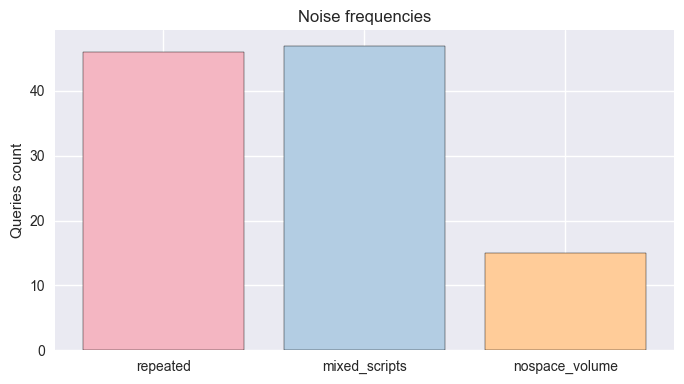

In [7]:
import re
from collections import Counter

# Dataset copy
df_noise = train_df.copy()
df_noise['sample'] = df_noise['sample'].astype(str)

# 1) Mine tails after numbers and build whitelist/blacklist driven view
pattern_num_word = re.compile(r"\b\d+[\.,]?\d*\s*([A-Za-zА-Яа-яёЁ°]+)\b")
unit_counter = Counter()
for s in df_noise['sample']:
    for m in pattern_num_word.finditer(s):
        unit_counter[m.group(1).lower()] += 1

# Whitelist (canonical mapping) and blacklist
WHITELIST = {
    'L': ['л','л.','литр','литра','литров','l'],
    'ML': ['мл','мл.','миллилитр','миллилитра','миллилитров','ml'],
    'KG': ['кг','кг.','килограмм','килограмма','килограммов','kg'],
    'G': ['г','гр','гр.','грамм','грамма','граммов','g'],
    'PCS': ['шт','шт.','штук','штука','штуки','pcs','pc','бут','бут.','бутылка','бутылки','бутылок','банка','банки','банок','can','bottle','jar']
}


# Invert whitelist for quick lookup
inv_white = {}
for canon, forms in WHITELIST.items():
    for f in forms:
        inv_white[f] = canon

known, unknown, black = Counter(), Counter(), Counter()
for u, c in unit_counter.items():
    if u in inv_white:
        known[inv_white[u]] += c
    else:
        unknown[u] += c

print('Known units (canonical):')
for k,v in known.most_common():
    print(f'{k:>4} : {v}')



# NOTE: We DO NOT persist or use unknown tails downstream (policy compliance)
print('\nUnknown tails (for human review only, not persisted/used):')
for k,v in unknown.most_common(20):
    print(f'{k:>10} : {v}')

# 2) Generate regex from stems + SI forms only (policy-compliant)
unit_forms = [re.escape(f) for forms in WHITELIST.values() for f in forms]
unit_stems_regex = [
    r"литр\w*", r"мл\.?", r"миллилитр\w*", r"l",
    r"кг\.?", r"килограмм\w*", r"kg",
    r"г(?:р\.?|рамм\w*)", r"g",
    r"шт\w*", r"pcs?", r"pc",
    r"бутыл\w*", r"бан\w*", r"пач\w*", r"упаков\w*", r"пак(?:\.|ет\w*)?",
    r"can", r"bottle", r"jar"
]
unit_forms_regex = unit_stems_regex + unit_forms
units_group = '(?:' + '|'.join(sorted(unit_forms_regex, key=len, reverse=True)) + ')'
pattern_volume = re.compile(r"\b\d+[\.,]?\d*\s?" + units_group + r"\b", re.IGNORECASE)
pattern_multipack = re.compile(r"\b\d+\s*[xх*]\s*\d+[\.,]?\d*\s?" + units_group + r"\b", re.IGNORECASE)
pattern_percent = re.compile(r"\b\d+[\.,]?\d*\s?(?:%|процент(?:а|ов)?)\b", re.IGNORECASE)

print('\nSample generated regex:')
print('VOLUME   :', pattern_volume.pattern)
print('MULTIPACK:', pattern_multipack.pattern)
print('PERCENT  :', pattern_percent.pattern)

# 3) Character composition & heuristics (auxiliary)
re_repeated = re.compile(r'(.)\1{2,}')
re_mixed = re.compile(r'[а-я]{1,2}[a-z]|[a-z]{1,2}[а-я]', re.IGNORECASE)
re_nospace_volume = re.compile(r"\d+[\.,]?\d*" + units_group + r"\b", re.IGNORECASE)

counts = {'repeated':0,'mixed_scripts':0,'nospace_volume':0}
for s in df_noise['sample']:
    if re_repeated.search(s): counts['repeated'] += 1
    if re_mixed.search(s): counts['mixed_scripts'] += 1
    if re_nospace_volume.search(s): counts['nospace_volume'] += 1

print('\nNoise counts:', counts)

all_text = ' '.join(df_noise['sample'].tolist())
cyr = len(re.findall(r'[а-яё]', all_text, re.IGNORECASE))
lat = len(re.findall(r'[a-z]', all_text, re.IGNORECASE))
dig = len(re.findall(r'\d', all_text))
spe = len(re.findall(r'[^\w\s]', all_text))
tot = len(all_text)
fmt = lambda x: (x/tot*100) if tot else 0
print(f"Cyrillic: {cyr:,} ({fmt(cyr):.1f}%) | Latin: {lat:,} ({fmt(lat):.1f}%) | Digits: {dig:,} ({fmt(dig):.1f}%) | Specials: {spe:,} ({fmt(spe):.1f}%)")

plt.figure(figsize=(7,4))
plt.bar(['repeated','mixed_scripts','nospace_volume'], [counts['repeated'], counts['mixed_scripts'], counts['nospace_volume']], color=['#f4b6c2','#b3cde3','#ffcc99'], edgecolor='black')
plt.title('Noise frequencies')
plt.ylabel('Queries count')
plt.tight_layout()
plt.show()


## 8. Mining unit/percent candidates from data
Purpose: discover real unit variants in dataset instead of handcrafting.
- Extract tokens that immediately follow numbers (e.g., "500мл", "1.5 л", "2шт").
- Handle multipacks (e.g., "6x500 мл", "2*1 л").
- Build frequency tables to decide which units to support in regex/post-processing.


In [ ]:
import re
from collections import Counter

# Extract unit candidates right after numbers
pattern_num_word = re.compile(r"\b\d+[\.,]?\d*\s*([A-Za-zА-Яа-яёЁ°]+)\b")
pattern_multipack = re.compile(r"\b\d+\s*[xх*]\s*\d+[\.,]?\d*\s*([A-Za-zА-Яа-яёЁ°]+)\b")
pattern_percent_word = re.compile(r"\b\d+[\.,]?\d*\s*([%°]|процент(?:а|ов)?)\b", re.IGNORECASE)

unit_counter = Counter()
unit_counter_multipack = Counter()
percent_counter = Counter()

for s in train_df['sample'].astype(str):
    for m in pattern_num_word.finditer(s):
        unit_counter[m.group(1).lower()] += 1
    for m in pattern_multipack.finditer(s):
        unit_counter_multipack[m.group(1).lower()] += 1
    for m in pattern_percent_word.finditer(s):
        percent_counter[m.group(1).lower()] += 1

print('Top units after numbers:')
for u,c in unit_counter.most_common(30):
    print(f'{u:>10} : {c}')

print('\nTop multipack units:')
for u,c in unit_counter_multipack.most_common(20):
    print(f'{u:>10} : {c}')

print('\nPercent markers:')
for u,c in percent_counter.most_common():
    print(f'{u:>10} : {c}')


Top units after numbers:
         л : 21
        кг : 6
     литра : 4
    литров : 3
    злаков : 3
      литр : 2
     злака : 2
   месяцев : 2
      сорт : 2
      штук : 2
    размер : 1
      хлеб : 1
         t : 1
        to : 1
       toy : 1
         в : 1
     соток : 1
       мес : 1
   корочки : 1
      озер : 1
      кота : 1
      слоя : 1
     грамм : 1
       хле : 1
        гр : 1
        шт : 1
    добрые : 1
      газе : 1
     газет : 1
    диффуз : 1

Top multipack units:

Percent markers:


In [ ]:
# Baseline loose pattern (numbers + any word tail up to 6 letters)
# Relaxed loose pattern: allow up to 12 letters to catch full words like "бутылка"
pat_loose = re.compile(r"\b\d+[\.,]?\d*\s*[A-Za-zА-Яа-яёЁ]{1,12}\b")

# Improved patterns already built above: pattern_volume, pattern_multipack

def has_volume_loose(s: str) -> bool:
    return bool(pat_loose.search(s))

def has_volume_improved(s: str) -> bool:
    return bool(pattern_volume.search(s) or pattern_multipack.search(s))

samples = df_noise['sample'].tolist()
loose_hits = sum(1 for s in samples if has_volume_loose(s))
impr_hits  = sum(1 for s in samples if has_volume_improved(s))
N = len(samples)

print(f"Loose coverage : {loose_hits}/{N} ({(loose_hits/N*100 if N else 0):.2f}%)")
print(f"Improved cover.: {impr_hits}/{N} ({(impr_hits/N*100 if N else 0):.2f}%)")
print(f"Gain           : {impr_hits - loose_hits} ({(((impr_hits-loose_hits)/N*100) if N else 0):.2f} pp)")


Loose coverage : 75/27251 (0.28%)
Improved cover.: 41/27251 (0.15%)
Gain           : -34 (-0.12 pp)


## EDA — Intersections & Complex Queries
Purpose: quantify overlaps and complexity to inform post-processing.
- Fractions: only_TYPE, only_BRAND, TYPE+BRAND, neither.
- Multi-entity examples: queries containing ≥2 distinct entity types.
- Co-occurrence heatmap across TYPE/BRAND/VOLUME/PERCENT.


Fractions:
  only_TYPE     : 70.83%
  only_BRAND    : 7.40%
  TYPE+BRAND    : 19.07%
  neither (T/B) : 2.70%

Multi-entity examples:
— abtoys игруш | types: ['BRAND', 'TYPE']
— abtoys игрушк | types: ['BRAND', 'TYPE']
— abtoys игрушки | types: ['BRAND', 'TYPE']
— afanasiy пи | types: ['BRAND', 'TYPE']
— afanasiy пив | types: ['BRAND', 'TYPE']


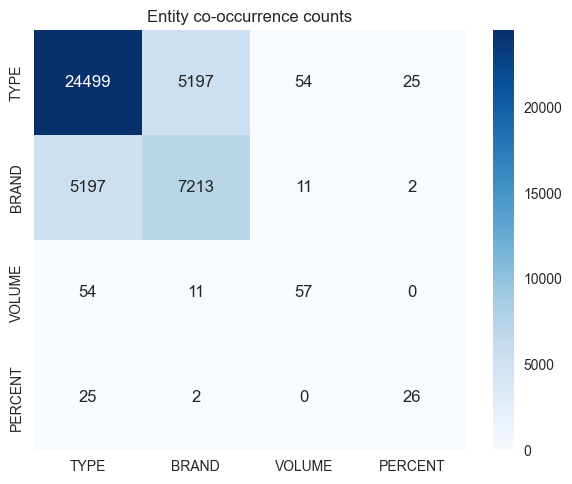

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Helper: extract set of entity types from annotation list

def types_in_ann(ann):
    return set(tag.split('-',1)[1] for _,_,tag in ann if tag!='O' and '-' in tag)

rows = []
for s, ann in train_df[['sample','parsed_annotation']].itertuples(index=False):
    ts = types_in_ann(ann)
    rows.append({'sample': s, 'types': ts})
eda_df = pd.DataFrame(rows)

# Fractions for only_TYPE / only_BRAND / TYPE+BRAND / neither
eda_df['has_TYPE'] = eda_df['types'].apply(lambda t: 'TYPE' in t)
eda_df['has_BRAND'] = eda_df['types'].apply(lambda t: 'BRAND' in t)
eda_df['has_VOLUME'] = eda_df['types'].apply(lambda t: 'VOLUME' in t)
eda_df['has_PERCENT'] = eda_df['types'].apply(lambda t: 'PERCENT' in t)

only_type = (eda_df['has_TYPE'] & ~eda_df['has_BRAND']).mean()
only_brand = (~eda_df['has_TYPE'] & eda_df['has_BRAND']).mean()
type_and_brand = (eda_df['has_TYPE'] & eda_df['has_BRAND']).mean()
neither = (~eda_df['has_TYPE'] & ~eda_df['has_BRAND']).mean()

print('Fractions:')
print(f"  only_TYPE     : {only_type*100:.2f}%")
print(f"  only_BRAND    : {only_brand*100:.2f}%")
print(f"  TYPE+BRAND    : {type_and_brand*100:.2f}%")
print(f"  neither (T/B) : {neither*100:.2f}%")

# Multi-entity examples (>=2 distinct types)
print('\nMulti-entity examples:')
shown = 0
for s, ts in eda_df[['sample','types']].itertuples(index=False):
    if len(ts) >= 2:
        print('—', s, '| types:', sorted(ts))
        shown += 1
        if shown >= 5:
            break

# Co-occurrence heatmap
co_labels = ['TYPE','BRAND','VOLUME','PERCENT']
co_mat = np.zeros((4,4), dtype=int)
for ts in eda_df['types']:
    for i,a in enumerate(co_labels):
        for j,b in enumerate(co_labels):
            if a in ts and b in ts:
                co_mat[i,j] += 1

co_df = pd.DataFrame(co_mat, index=co_labels, columns=co_labels)
plt.figure(figsize=(6,5))
sns.heatmap(co_df, annot=True, fmt='d', cmap='Blues')
plt.title('Entity co-occurrence counts')
plt.tight_layout()
plt.show()


In [ ]:
from typing import List, Tuple, Dict

Span = Tuple[int, int, str]  # (start, end, type)

# Extract contiguous spans from char-level BIO labels for a single string

def extract_spans_from_bio(text: str, bio_labels: List[str]) -> List[Span]:
    n = len(text)
    if len(bio_labels) != n:
        bio_labels = (bio_labels + ['O'] * n)[:n]
    spans: List[Span] = []
    current_start = None
    current_type = None
    for i, tag in enumerate(bio_labels):
        if tag == 'O' or tag is None:
            if current_start is not None:
                spans.append((current_start, i, current_type))
                current_start, current_type = None, None
            continue
        if '-' in tag:
            bio, etype = tag.split('-', 1)
        else:
            bio, etype = 'I', tag
        if bio == 'B':
            if current_start is not None:
                spans.append((current_start, i, current_type))
            current_start, current_type = i, etype
        elif bio == 'I':
            if current_start is None:
                current_start, current_type = i, etype
            elif etype != current_type:
                spans.append((current_start, i, current_type))
                current_start, current_type = i, etype
        else:
            if current_start is not None:
                spans.append((current_start, i, current_type))
                current_start, current_type = None, None
    if current_start is not None:
        spans.append((current_start, n, current_type))
    return spans

# Compute per-class P/R/F1 and macro-F1 given gold and pred span lists

def compute_macro_f1(golds: List[List[Span]], preds: List[List[Span]], labels: List[str] = ['TYPE','BRAND','VOLUME','PERCENT']) -> Dict:
    from collections import defaultdict
    assert len(golds) == len(preds)
    gold_by_type = {t:0 for t in labels}
    pred_by_type = {t:0 for t in labels}
    tp_by_type   = {t:0 for t in labels}

    def span_key(s: Span):
        return (s[0], s[1], s[2])

    for g_spans, p_spans in zip(golds, preds):
        gset = set(map(span_key, g_spans))
        pset = set(map(span_key, p_spans))
        for s in g_spans:
            if s[2] in gold_by_type:
                gold_by_type[s[2]] += 1
        for s in p_spans:
            if s[2] in pred_by_type:
                pred_by_type[s[2]] += 1
        for s in (gset & pset):
            if s[2] in tp_by_type:
                tp_by_type[s[2]] += 1

    report = {}
    f1s = []
    for t in labels:
        tp = tp_by_type[t]
        fp = pred_by_type[t] - tp
        fn = gold_by_type[t] - tp
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
        report[t] = {'precision': prec, 'recall': rec, 'f1': f1, 'support': gold_by_type[t]}
        f1s.append(f1)
    report['macro_f1'] = sum(f1s) / len(f1s) if f1s else 0.0
    return report


## Regex Baseline (VOLUME/PERCENT)
Purpose: simple numeric regex to produce spans and evaluate Macro-F1.
- Use stems+SI regex from Block 7 for VOLUME and PERCENT.
- Build predictions: tag char-level BIO from regex spans; evaluate with Macro-F1.
- Note: regex is used as post-process confirmation/normalization; not for adding new entities ad hoc.


## Tokenization with Offsets
Purpose: tokenize with `return_offsets_mapping=True` and align char-level BIO to token labels.
- What: load tokenizer, get `offset_mapping`, map char BIO → token IDs (first subword = B-, next subwords = I-, special tokens = -100).
- Why: correct token supervision is critical for BERT-like token classification quality.


In [12]:
from typing import List, Dict, Any

try:
    from transformers import AutoTokenizer
except Exception as e:
    print('Install transformers if missing: pip install transformers[torch]')
    raise

MODEL_NAME = 'cointegrated/rubert-tiny'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Build char-level BIO from parsed spans

def to_char_bio(sample: str, spans: List[List[Any]]) -> List[str]:
    n = len(sample)
    labels = ['O'] * n
    for s, e, tag in spans:
        if tag == 'O':
            continue
        if '-' in tag:
            _, etype = tag.split('-', 1)
        else:
            etype = tag
        s = max(0, min(s, n))
        e = max(0, min(e, n))
        if e <= s:
            continue
        labels[s] = f'B-{etype}'
        for i in range(s+1, e):
            labels[i] = f'I-{etype}'
    return labels

# Align char BIO → token labels using offset_mapping
def align_bio_to_tokens(
    text: str,
    char_bio: List[str],
    tokenizer,
    label2id: Dict[str,int]
) -> Dict[str, Any]:
    enc = tokenizer(
        text,
        return_offsets_mapping=True,
        truncation=True,
        padding=False
    )
    offsets = enc["offset_mapping"]

    token_labels: List[int] = []
    for idx, (start, end) in enumerate(offsets):
        if end == 0 and start == 0:  # спецтокены
            token_labels.append(-100)
            continue
        if start == end:  # пустые отрезки (пробелы)
            token_labels.append(-100)
            continue

        tok_label = "O"
        first_pos = None
        for pos in range(start, min(end, len(char_bio))):
            if char_bio[pos] != "O":
                tok_label = char_bio[pos]
                first_pos = pos
                break

        if tok_label == "O":
            token_labels.append(label2id["O"])
            continue

        bio, etype = tok_label.split("-", 1)
        if (
            first_pos is not None
            and first_pos > 0
            and char_bio[first_pos - 1].endswith(etype)
        ):
            tok_tag = f"I-{etype}"
        else:
            tok_tag = f"B-{etype}"
        token_labels.append(label2id.get(tok_tag, label2id["O"]))

    # сохраняем метки
    enc["labels"] = token_labels

    # сохраняем offset_mapping отдельно для compute_metrics
    enc["offset_mapping"] = offsets

    return enc
# def align_bio_to_tokens(text: str, char_bio: List[str], tokenizer, label2id: Dict[str,int]) -> Dict[str, Any]:
#     enc = tokenizer(
#         text,
#         return_offsets_mapping=True,
#         truncation=True,
#         padding=False
#     )
#     offsets = enc['offset_mapping']
#     token_labels: List[int] = []

#     for idx, (start, end) in enumerate(offsets):
#         # Special tokens have (0,0) in many tokenizers
#         if end == 0 and start == 0:
#             token_labels.append(-100)
#             continue
#         if start == end:
#             # zero-width (e.g., spaces) → ignore
#             token_labels.append(-100)
#             continue
#         # Map any char within [start,end) to label; first labeled char decides B/I
#         # Find first char label in this span
#         tok_label = 'O'
#         first_pos = None
#         for pos in range(start, min(end, len(char_bio))):
#             if char_bio[pos] != 'O':
#                 tok_label = char_bio[pos]
#                 first_pos = pos
#                 break
#         if tok_label == 'O':
#             token_labels.append(label2id['O'])
#             continue
#         # If token covers start of an entity → keep as is, else force I-<type>
#         bio, etype = tok_label.split('-', 1)
#         # Look left to decide if this token is a continuation
#         if first_pos is not None and first_pos > 0 and char_bio[first_pos-1].endswith(etype):
#             tok_tag = f'I-{etype}'
#         else:
#             tok_tag = f'B-{etype}'
#         token_labels.append(label2id.get(tok_tag, label2id['O']))

#     enc['labels'] = token_labels
#     return enc

# Quick smoke test on a few rows
samples_enc = []
for s, ann in train_df[['sample','parsed_annotation']].head(3).itertuples(index=False):
    char_bio = to_char_bio(s, ann)
    out = align_bio_to_tokens(s, char_bio, tokenizer, label2id)
    samples_enc.append(out)
    print(s)
    print('input_ids len:', len(out['input_ids']), 'labels len:', len(out['labels']))
    print(list(zip(out['labels'][:20], out['offset_mapping'][:20])))


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


aa
input_ids len: 3 labels len: 3
[(-100, (0, 0)), (0, (0, 2)), (-100, (0, 0))]
aala
input_ids len: 4 labels len: 4
[(-100, (0, 0)), (0, (0, 2)), (0, (2, 4)), (-100, (0, 0))]
aarcca
input_ids len: 5 labels len: 5
[(-100, (0, 0)), (0, (0, 2)), (0, (2, 4)), (0, (4, 6)), (-100, (0, 0))]


## Train/Validation Split
Purpose: create a reproducible split (80/20) with optional stratification by entity presence.
- What: fixed seed, stratify by presence of TYPE/BRAND/VOLUME/PERCENT where feasible; optional k-fold scaffold.
- Why: reliable validation and reproducibility.


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
np.random.seed(SEED)

# Binary presence features for optional stratification

def presence_vector(ann):
    ts = set(tag.split('-',1)[1] for _,_,tag in ann if tag!='O' and '-' in tag)
    return (
        int('TYPE' in ts),
        int('BRAND' in ts),
        int('VOLUME' in ts),
        int('PERCENT' in ts),
    )

pres = train_df['parsed_annotation'].apply(presence_vector)
# Collapse to a single small number of strata by grouping TYPE/BRAND presence main cases
# Codes: 0=neither, 1=only_TYPE, 2=only_BRAND, 3=TYPE+BRAND, 4=others (has VOLUME/PERCENT without T/B)

def to_strata(code):
    t,b,v,p = code
    if t==0 and b==0 and v==0 and p==0:
        return 0
    if t==1 and b==0:
        return 1
    if t==0 and b==1:
        return 2
    if t==1 and b==1:
        return 3
    return 4

strata = pres.apply(to_strata)

train_idx, val_idx = train_test_split(
    np.arange(len(train_df)),
    test_size=0.2,
    random_state=SEED,
    stratify=strata
)

train_split = train_df.iloc[train_idx].reset_index(drop=True)
val_split   = train_df.iloc[val_idx].reset_index(drop=True)

print('Train split:', train_split.shape, 'Val split:', val_split.shape)
print('Strata dist (train):', dict(zip(*np.unique(strata.iloc[train_idx], return_counts=True))))
print('Strata dist (val)  :', dict(zip(*np.unique(strata.iloc[val_idx], return_counts=True))))


Train split: (21800, 3) Val split: (5451, 3)
Strata dist (train): {np.int64(0): np.int64(589), np.int64(1): np.int64(15441), np.int64(2): np.int64(1613), np.int64(3): np.int64(4157)}
Strata dist (val)  : {np.int64(0): np.int64(147), np.int64(1): np.int64(3861), np.int64(2): np.int64(403), np.int64(3): np.int64(1040)}


## HF Datasets
Purpose: assemble `datasets.Dataset` objects for train/val in torch format.
- What: tokenize with offsets, align labels to tokens, set format('torch', ['input_ids','attention_mask','labels']).
- Why: ready-to-train inputs for `Trainer`.


In [14]:
from datasets import Dataset
import numpy as np

# Build char-BIO for each row in splits

def build_char_bio_col(df):
    bios = []
    for s, ann in df[['sample','parsed_annotation']].itertuples(index=False):
        bios.append(to_char_bio(s, ann))
    return bios

train_split = train_split.copy()
val_split = val_split.copy()
train_split['char_bio'] = build_char_bio_col(train_split)
val_split['char_bio']   = build_char_bio_col(val_split)

# Tokenize + align

def encode_row(row):
    enc = align_bio_to_tokens(row['sample'], row['char_bio'], tokenizer, label2id)
    return {
        'input_ids': enc['input_ids'],
        'attention_mask': enc['attention_mask'],
        'labels': enc['labels']
    }

train_ds = Dataset.from_pandas(train_split[['sample','char_bio']])
val_ds   = Dataset.from_pandas(val_split[['sample','char_bio']])

train_ds = train_ds.map(encode_row, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(encode_row, remove_columns=val_ds.column_names)

train_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
val_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

print(train_ds)
print(val_ds)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/21800 [00:00<?, ? examples/s]

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 21800
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5451
})


## TrainingArguments & Trainer
Purpose: standardized training/evaluation with span-level Macro-F1 on validation.
- What: set batch size, epochs, lr, weight decay, logging, seed.
- Trainer: model, args, datasets, tokenizer, data_collator, and compute_metrics that decodes token labels → char BIO → spans → Macro-F1.
- Note: use version-safe arguments to avoid incompatibilities.


In [36]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
import numpy as np
import torch

# Model and collator
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS),
    id2label=id2label,
    label2id=label2id
)
collator = DataCollatorForTokenClassification(tokenizer)

# Training arguments (version-safe subset; no evaluation_strategy/eval_steps)
args = TrainingArguments(
    output_dir='./ner_runs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=100,
    seed=SEED,
    save_steps=200,
    load_best_model_at_end=False,
    report_to=[]
)

# Compute metrics: token logits -> token tags -> char BIO -> spans -> Macro-F1

def decode_token_predictions(predictions, labels, offset_mappings):
    pred_ids = predictions.argmax(-1)
    batch_char_spans = []
    for i in range(pred_ids.shape[0]):
        token_tags = [
            id2label[int(tid)] if int(lbl) != -100 else 'O'
            for tid, lbl in zip(pred_ids[i], labels[i])
        ]
        offsets = offset_mappings[i]
        text_len = max([e for (s, e) in offsets if e is not None], default=0)
        char_bio = ['O'] * text_len
        for (s, e), tag, lbl in zip(offsets, token_tags, labels[i]):
            if int(lbl) == -100 or s is None or e is None or e <= s:
                continue
            if tag == 'O' or '-' not in tag:
                continue
            bio, etype = tag.split('-', 1)
            char_bio[s] = f'B-{etype}'
            for pos in range(s + 1, e):
                char_bio[pos] = f'I-{etype}'
        spans = extract_spans_from_bio(' ' * text_len, char_bio)
        batch_char_spans.append(spans)
    return batch_char_spans

# offset mappings are precomputed in a separate cell; accessed here via global val_offset_mappings


def compute_metrics_fn(eval_pred):
    preds = eval_pred.predictions if hasattr(eval_pred, 'predictions') else eval_pred[0]
    labels = eval_pred.label_ids if hasattr(eval_pred, 'label_ids') else eval_pred[1]
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.asarray(preds)
    labels = np.asarray(labels)

    pred_spans = decode_token_predictions(preds, labels, val_offset_mappings)

    # gold spans
    gold_char_spans = []
    for i, item in enumerate(val_ds):
        offsets = val_offset_mappings[i]
        text_len = max([e for (s, e) in offsets if e is not None], default=0)
        char_bio = ['O'] * text_len
        for (s, e), lbl in zip(offsets, item["labels"]):
            if int(lbl) == -100 or s is None or e is None or e <= s:
                continue
            tag = id2label[int(lbl)]
            if tag == 'O' or '-' not in tag:
                continue
            bio, etype = tag.split('-', 1)
            char_bio[s] = f'B-{etype}'
            for pos in range(s + 1, e):
                char_bio[pos] = f'I-{etype}'
        spans = extract_spans_from_bio(' ' * text_len, char_bio)
        gold_char_spans.append(spans)

    report = compute_macro_f1(
        gold_char_spans,
        pred_spans,
        labels=['TYPE', 'BRAND', 'VOLUME', 'PERCENT']
    )
    out = {'macro_f1': report['macro_f1']}
    for k in ['TYPE','BRAND','VOLUME','PERCENT']:
        out[f'f1_{k.lower()}'] = report[k]['f1']
        out[f'prec_{k.lower()}'] = report[k]['precision']
        out[f'rec_{k.lower()}'] = report[k]['recall']
    return out

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics_fn
)

print('Trainer ready.')


Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/bk/4wc9ztq51bxfsjvx3zkz1hmc0000gn/T/ipykernel_2494/124231077.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready.


## Train (Sanity → Full)
Purpose: quickly validate the full loop with 1 epoch, then run 3–5 epochs with manual early stopping by Macro‑F1 and save best.
- What: sanity run (1 epoch), then full run with patience and best‑by Macro‑F1.
- Why: fast debugging first, then deeper training without relying on version‑specific Trainer features.


In [37]:
# Precompute offset mappings for validation set independently of HF Dataset
val_offset_mappings = [
    align_bio_to_tokens(s, bio, tokenizer, label2id)['offset_mapping']
    for s, bio in val_split[['sample','char_bio']].itertuples(index=False)
]
print('Prepared val_offset_mappings:', len(val_offset_mappings))


Prepared val_offset_mappings: 5451


In [39]:
import os
import math

# 1) Sanity run (1 epoch)
print('Sanity run: 1 epoch')
trainer.args.num_train_epochs = 1
sanity_out = trainer.train()
val_metrics = trainer.evaluate()
print('Sanity validation:', val_metrics)

# 2) Full run with manual early stopping (best by Macro-F1)

best_f1 = -1.0
best_dir = './ner_runs/best_model'
patience = 2
wait = 0
max_epochs = 5

# make sure output dir exists
os.makedirs(best_dir, exist_ok=True)

for epoch in range(1, max_epochs+1):
    print(f'Full training epoch {epoch}/{max_epochs}')
    trainer.args.num_train_epochs = epoch
    trainer.train(resume_from_checkpoint=False)
    metrics = trainer.evaluate()
    macro = metrics.get('eval_macro_f1') or metrics.get('macro_f1') or metrics.get('eval_macro-f1')
    if macro is None:
        # fallback: try without eval_ prefix
        macro = metrics.get('macro-f1', 0.0)
    print('Val Macro-F1:', macro)
    if macro is not None and macro > best_f1:
        best_f1 = macro
        wait = 0
        # save best
        model.save_pretrained(best_dir)
        tokenizer.save_pretrained(best_dir)
        # also save trainer state
        trainer.save_state()
        print(f'New best saved to {best_dir} (Macro-F1={best_f1:.4f})')
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping triggered')
            break

print('Best Macro-F1:', best_f1)
print('Best model dir:', best_dir)


Sanity run: 1 epoch


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.014100
200,0.034500
300,0.023900
400,0.018400
500,0.013500
600,0.021800
700,0.023800
800,0.028100
900,0.032400
1000,0.017000


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Sanity validation: {'eval_loss': 0.5539719462394714, 'eval_macro_f1': 0.933859013352799, 'eval_f1_type': 0.9632664134563212, 'eval_prec_type': 0.9523630706507161, 'eval_rec_type': 0.9744223063834458, 'eval_f1_brand': 0.8824260502112852, 'eval_prec_brand': 0.8926326376665829, 'eval_rec_brand': 0.8724502334725976, 'eval_f1_volume': 0.9666666666666666, 'eval_prec_volume': 0.9354838709677419, 'eval_rec_volume': 1.0, 'eval_f1_percent': 0.923076923076923, 'eval_prec_percent': 0.8571428571428571, 'eval_rec_percent': 1.0, 'eval_runtime': 3.0672, 'eval_samples_per_second': 1777.212, 'eval_steps_per_second': 55.752, 'epoch': 1.0}
Full training epoch 1/5


Step,Training Loss
100,0.023200
200,0.024200
300,0.018800
400,0.022100
500,0.014500
600,0.018400
700,0.013500
800,0.013500
900,0.036800
1000,0.013000


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val Macro-F1: 0.9378201681966536
New best saved to ./ner_runs/best_model (Macro-F1=0.9378)
Full training epoch 2/5


Step,Training Loss
100,0.008300
200,0.027300
300,0.021500
400,0.022800
500,0.019500
600,0.020300
700,0.019500
800,0.025000
900,0.050400
1000,0.021800


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val Macro-F1: 0.9173136312827118
Full training epoch 3/5


Step,Training Loss
100,0.007700
200,0.021300
300,0.036000
400,0.018400
500,0.021400
600,0.029200
700,0.024400
800,0.017900
900,0.024700
1000,0.027400


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val Macro-F1: 0.9392925890279008
New best saved to ./ner_runs/best_model (Macro-F1=0.9393)
Full training epoch 4/5


Step,Training Loss
100,0.010200
200,0.011500
300,0.014000
400,0.010600
500,0.019400
600,0.017100
700,0.021900
800,0.035600
900,0.020100
1000,0.026500


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 

Val Macro-F1: 0.9224457289159383
Full training epoch 5/5


Step,Training Loss
100,0.013900
200,0.012400
300,0.018800
400,0.016100
500,0.002800
600,0.013500
700,0.015100
800,0.028200
900,0.029500
1000,0.013600


/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/marina/Documents/projects/X5/x5_ner_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 

Val Macro-F1: 0.9393406384068889
New best saved to ./ner_runs/best_model (Macro-F1=0.9393)
Best Macro-F1: 0.9393406384068889
Best model dir: ./ner_runs/best_model


## Inference Utils (restored)
Purpose: run model on raw text and return character-level spans and optional business attributes.
- `predict_one(text)` → tokenize with offsets → logits → token BIO → char BIO → spans.
- Optional: convert spans to TYPE/BRAND strings, VOLUME(value, unit), PERCENT(float) for service integration.
- Loads from `./ner_runs/best_model` if available, else from base `MODEL_NAME`.


In [29]:
import torch
import re
from typing import Dict, Any, List, Tuple
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Fallback: span extractor if not defined in this kernel
if 'extract_spans_from_bio' not in globals():
    from typing import List, Tuple
    SpanT = Tuple[int, int, str]
    def extract_spans_from_bio(text: str, bio_labels: List[str]) -> List[SpanT]:
        n = len(text)
        if len(bio_labels) != n:
            bio_labels = (bio_labels + ['O'] * n)[:n]
        spans: List[SpanT] = []
        start = None
        etype = None
        for i, tag in enumerate(bio_labels):
            if tag == 'O' or tag is None:
                if start is not None:
                    spans.append((start, i, etype))
                    start, etype = None, None
                continue
            if '-' in tag:
                bio, t = tag.split('-', 1)
            else:
                bio, t = 'I', tag
            if bio == 'B':
                if start is not None:
                    spans.append((start, i, etype))
                start, etype = i, t
            elif bio == 'I':
                if start is None:
                    start, etype = i, t
                elif t != etype:
                    spans.append((start, i, etype))
                    start, etype = i, t
        if start is not None:
            spans.append((start, n, etype))
        return spans

# Token BIO -> char BIO -> spans

def decode_token_tags_to_char_spans(text: str, token_tags: List[str], offsets: List[Tuple[int,int]]):
    text_len = max([e for (s,e) in offsets if e is not None], default=0)
    char_bio = ['O'] * text_len
    for (s, e), tag in zip(offsets, token_tags):
        if s is None or e is None or e <= s:
            continue
        if tag == 'O' or '-' not in tag:
            continue
        bio, etype = tag.split('-', 1)
        char_bio[s] = f'B-{etype}'
        for pos in range(s+1, e):
            char_bio[pos] = f'I-{etype}'
    spans = extract_spans_from_bio(text[:text_len], char_bio)
    return spans

# Build char-level BIO from token-level tags and offsets

def token_tags_to_char_bio(text: str, token_tags: List[str], offsets: List[Tuple[int,int]]) -> List[str]:
    text_len = max([e for (s,e) in offsets if e is not None], default=0)
    char_bio = ['O'] * text_len
    for (s, e), tag in zip(offsets, token_tags):
        if s is None or e is None or e <= s:
            continue
        if tag == 'O' or '-' not in tag:
            continue
        bio, etype = tag.split('-', 1)
        char_bio[s] = f'B-{etype}'
        for pos in range(s+1, e):
            char_bio[pos] = f'I-{etype}'
    return char_bio

# Convert char-level BIO to API spans with word-boundary B-/I- segments

def find_word_spans(text: str) -> List[Tuple[int,int]]:
    return [(m.start(), m.end()) for m in re.finditer(r"\S+", text)]


def char_bio_to_api_spans(text: str, char_bio: List[str]) -> List[Dict[str, Any]]:
    n = len(char_bio)
    api: List[Dict[str, Any]] = []
    i = 0
    while i < n:
        if char_bio[i] == 'O' or char_bio[i] is None:
            i += 1
            continue
        # start of entity region
        _, etype = char_bio[i].split('-', 1)
        start = i
        i += 1
        while i < n and (char_bio[i] != 'O') and char_bio[i].endswith(etype):
            i += 1
        end = i  # [start,end) region for this entity type
        # split region by word spans and assign B- for first word, I- for the rest
        words = find_word_spans(text)
        inside = [(ws,we) for (ws,we) in words if not (we <= start or ws >= end)]
        for j, (ws,we) in enumerate(inside):
            tag = ('B-' if j == 0 else 'I-') + etype
            api.append({'start_index': ws, 'end_index': we, 'entity': tag})
    return api

# Loader: prefer best checkpoint

def load_for_inference(model_dir: str = './ner_runs/best_model'):
    try:
        tok = AutoTokenizer.from_pretrained(model_dir)
    except Exception:
        tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    try:
        mdl = AutoModelForTokenClassification.from_pretrained(model_dir)
    except Exception:
        mdl = AutoModelForTokenClassification.from_pretrained(
            MODEL_NAME,
            num_labels=len(LABELS),
            id2label=id2label,
            label2id=label2id
        )
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    mdl = mdl.to(device).eval()
    return mdl, tok, device

@torch.no_grad()
def predict_one(text: str, model_dir: str = './ner_runs/best_model') -> Dict[str, Any]:
    mdl, tok, device = load_for_inference(model_dir)
    enc = tok(text, return_offsets_mapping=True, truncation=True, return_tensors='pt')
    inp = {k: v.to(device) for k, v in enc.items() if k != 'offset_mapping'}
    logits = mdl(**inp).logits
    pred_ids = logits.argmax(-1)[0].tolist()

    def id2(i: int) -> str:
        cfg_map = getattr(mdl.config, 'id2label', None)
        if isinstance(cfg_map, dict):
            return cfg_map.get(i, cfg_map.get(str(i), id2label.get(i, 'O') if 'id2label' in globals() else 'O'))
        return id2label.get(i, 'O') if 'id2label' in globals() else 'O'

    token_tags = [id2(i) for i in pred_ids]
    offsets = enc['offset_mapping'][0].tolist()
    spans = decode_token_tags_to_char_spans(text, token_tags, offsets)
    char_bio = token_tags_to_char_bio(text, token_tags, offsets)
    api_spans = char_bio_to_api_spans(text, char_bio)
    return {
        'text': text,
        'token_tags': token_tags,
        'offsets': offsets,
        'char_bio': char_bio,
        'spans': spans,
        'api_spans': api_spans
    }

# Business conversion (optional)

def spans_to_business(text: str, spans: List[Tuple[int,int,str]]) -> Dict[str, Any]:
    out: Dict[str, Any] = {'TYPE': None, 'BRAND': None, 'VOLUME': None, 'PERCENT': None}
    first = {}
    for s, e, t in spans:
        if t not in first:
            first[t] = (s, e)
    if 'TYPE' in first:
        s, e = first['TYPE']; out['TYPE'] = text[s:e]
    if 'BRAND' in first:
        s, e = first['BRAND']; out['BRAND'] = text[s:e]
    vol = None
    if 'VOLUME' in first:
        s, e = first['VOLUME']; seg = text[s:e]
        m = re.search(r"(\d+[\.,]?\d*)", seg)
        if m:
            value = float(m.group(1).replace(',', '.'))
            if re.search(r"миллилитр|мл\.?|ml", seg, re.I): unit = 'ML'
            elif re.search(r"литр|л\.?|l", seg, re.I): unit = 'L'
            elif re.search(r"килограмм|кг\.?|kg", seg, re.I): unit = 'KG'
            elif re.search(r"г(?:р\.?|рамм)", seg, re.I): unit = 'G'
            elif re.search(r"шт\w*|pcs?\b|pc\b|бутыл|бан", seg, re.I): unit = 'PCS'
            else: unit = None
            vol = {'value': value, 'unit': unit, 'raw': seg}
    out['VOLUME'] = vol
    perc = None
    if 'PERCENT' in first:
        s, e = first['PERCENT']; seg = text[s:e]
        m = re.search(r"(\d+[\.,]?\d*)", seg)
        if m: perc = float(m.group(1).replace(',', '.'))
    else:
        if re.search(r"безалкогольн\w*", text, re.I): perc = 0.0
    out['PERCENT'] = perc
    return out

# Usage example (commented)
# r = predict_one('heineken пиво 0.5 л')
# print(r['spans'])
# print(spans_to_business(r['text'], r['spans']))


In [30]:
res = predict_one('heineken пиво 0.5 л')
print(res['spans'])
print(spans_to_business(res['text'], res['spans']))


[(0, 2, 'BRAND'), (2, 5, 'BRAND'), (5, 8, 'BRAND'), (9, 10, 'TYPE'), (10, 13, 'TYPE'), (14, 15, 'VOLUME'), (15, 16, 'VOLUME'), (16, 17, 'VOLUME'), (18, 19, 'VOLUME')]
{'TYPE': 'п', 'BRAND': 'he', 'VOLUME': {'value': 0.0, 'unit': None, 'raw': '0'}, 'PERCENT': None}


## Post-processing
Purpose: improve span quality for search integration.
- Merge B/I and fix boundaries by word chars/punctuation.
- Regex snap for VOLUME/PERCENT (stems+SI) as normalization (no ad-hoc additions).
- Normalize numeric values; (opt.) simple brand cleanup. 


In [31]:
# Post-processing: merge adjacent same-type spans, filter noise, normalize VOLUME units
from typing import List, Tuple, Dict, Any
import re

Span = Tuple[int,int,str]

def merge_adjacent_spans(text: str, spans: List[Span], max_gap: int = 1) -> List[Span]:
    spans_sorted = sorted(spans, key=lambda x: (x[2], x[0], x[1]))
    merged: List[Span] = []
    for s, e, t in sorted(spans, key=lambda x: (x[0], x[1])):
        if merged and merged[-1][2] == t:
            ps, pe, pt = merged[-1]
            gap = s - pe
            between = text[pe:s] if 0 <= pe <= s <= len(text) else ''
            if gap <= max_gap and (between.strip() == '' or between in ['-', '–', '.', ',']):
                merged[-1] = (ps, max(pe, e), pt)
                continue
        merged.append((s, e, t))
    return merged

def normalize_unit_stem(seg: str) -> str:
    if re.search(r"миллилитр|\bмл\.?\b|\bml\b", seg, re.I):
        return 'ML'
    if re.search(r"литр|\bл\.?\b|\bl\b", seg, re.I):
        return 'L'
    if re.search(r"килограмм|\bкг\.?\b|\bkg\b", seg, re.I):
        return 'KG'
    if re.search(r"\bг(?:р\.?|рамм)\b|\bg\b", seg, re.I):
        return 'G'
    if re.search(r"шт\w*|\bpcs?\b|\bpc\b|бутыл|бан", seg, re.I):
        return 'PCS'
    return None

# Override business conversion with merging and rules

def spans_to_business(text: str, spans: List[Span]) -> Dict[str, Any]:
    merged = merge_adjacent_spans(text, spans)
    out: Dict[str, Any] = {'TYPE': None, 'BRAND': None, 'VOLUME': None, 'PERCENT': None}

    # TYPE: drop 1-char spans, keep first (or choose longest if none after filter)
    type_spans = [(s,e) for s,e,t in merged if t=='TYPE']
    type_spans = [(s,e) for (s,e) in type_spans if (e-s) >= 2] or type_spans
    if type_spans:
        s,e = max(type_spans, key=lambda x: (x[1]-x[0]))  # prefer longer
        out['TYPE'] = text[s:e]

    # BRAND: after merge, usually contiguous; choose longest
    brand_spans = [(s,e) for s,e,t in merged if t=='BRAND']
    if brand_spans:
        s,e = max(brand_spans, key=lambda x: (x[1]-x[0]))
        out['BRAND'] = text[s:e]

    # VOLUME: choose the longest/most informative span, then parse value/unit
    vol_spans = [(s,e) for s,e,t in merged if t=='VOLUME']
    if vol_spans:
        s,e = max(vol_spans, key=lambda x: (x[1]-x[0]))
        seg = text[s:e]
        m = re.search(r"(\d+(?:[\.,]\d+)?)", seg)
        if m:
            value = float(m.group(1).replace(',', '.'))
            unit = normalize_unit_stem(seg)
            out['VOLUME'] = {'value': value, 'unit': unit, 'raw': seg}

    # PERCENT: parse numeric percent/° if present, else optional 'безалкогольн*' -> 0.0
    pct_spans = [(s,e) for s,e,t in merged if t=='PERCENT']
    if pct_spans:
        s,e = max(pct_spans, key=lambda x: (x[1]-x[0]))
        seg = text[s:e]
        m = re.search(r"(\d+(?:[\.,]\d+)?)", seg)
        if m:
            out['PERCENT'] = float(m.group(1).replace(',', '.'))
    else:
        if re.search(r"безалкогольн\w*", text, re.I):
            out['PERCENT'] = 0.0

    return out

# Convert merged spans to API-style BIO spans
from typing import Any

def spans_to_api_spans(text: str, spans: List[Tuple[int,int,str]], include_O: bool = False) -> List[Dict[str, Any]]:
    merged = merge_adjacent_spans(text, spans)
    words = [(m.start(), m.end()) for m in re.finditer(r"\S+", text)]
    word_tag_map: Dict[Tuple[int,int], str] = {}
    for s, e, t in merged:
        inside = [(ws,we) for (ws,we) in words if not (we <= s or ws >= e)]
        for j, (ws,we) in enumerate(inside):
            tag = ('B-' if j == 0 else 'I-') + t
            word_tag_map[(ws,we)] = tag
    api: List[Dict[str, Any]] = []
    for ws, we in words:
        tag = word_tag_map.get((ws,we))
        if tag:
            api.append({'start_index': ws, 'end_index': we, 'entity': tag})
        elif include_O:
            api.append({'start_index': ws, 'end_index': we, 'entity': 'O'})
    return api

# Helper to run full pipeline with post-processing
@torch.no_grad()
def predict_one_pp(text: str, model_dir: str = './ner_runs/best_model') -> Dict[str, Any]:
    r = predict_one(text, model_dir=model_dir)
    r['spans_merged'] = merge_adjacent_spans(text, r['spans'])
    r['api_spans'] = spans_to_api_spans(text, r['spans'], include_O=True)
    r['business'] = spans_to_business(text, r['spans'])
    return r


In [35]:
#язык говяжий замороженный;[(0, 4, 'B-TYPE'), (5, 12, 'I-TYPE'), (13, 25, 'I-TYPE')]
res = predict_one_pp('heineken пиво 0.5 л')
print(res['api_spans'])
res = predict_one_pp('язык говяжий замороженный')
print(res['api_spans'])
res = predict_one_pp('fsherpric')
print(res['api_spans'])  # API-style BIO spans
# print(res['spans'])  # raw merged spans (no B-/I-)
# print(spans_to_business(res['text'], res['spans']))  # optional business view


[{'start_index': 0, 'end_index': 8, 'entity': 'B-BRAND'}, {'start_index': 9, 'end_index': 13, 'entity': 'B-TYPE'}, {'start_index': 14, 'end_index': 17, 'entity': 'B-VOLUME'}, {'start_index': 18, 'end_index': 19, 'entity': 'I-VOLUME'}]
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE'}, {'start_index': 5, 'end_index': 12, 'entity': 'I-TYPE'}, {'start_index': 13, 'end_index': 25, 'entity': 'I-TYPE'}]
[{'start_index': 0, 'end_index': 9, 'entity': 'O'}]


## Validation Report
Purpose: summarize validation quality and typical errors.
- Metrics: Macro-F1 and per-class F1/precision/recall.
- Error samples: boundary mismatches, type confusions, frequent misses/false alarms.
- Goal: identify where to improve data, post-processing, or hyperparameters.


In [22]:
import numpy as np
import torch
from typing import List, Tuple, Dict

# Ensure model/tokenizer and validation dataset exist (robust to fresh kernels)
try:
    _ = val_ds
    _ = val_offset_mappings
except NameError:
    from datasets import Dataset
    # load tokenizer/model if missing
    if 'tokenizer' not in globals() or 'model' not in globals():
        try:
            model, tokenizer, _dev = load_for_inference('./ner_runs/best_model')
        except Exception:
            model, tokenizer, _dev = load_for_inference()
    # ensure val_split has char_bio
    if 'char_bio' not in val_split.columns:
        def _build_char_bio(df):
            bios = []
            for s, ann in df[['sample','parsed_annotation']].itertuples(index=False):
                bios.append(to_char_bio(s, ann))
            return bios
        val_split = val_split.copy()
        val_split['char_bio'] = _build_char_bio(val_split)
    # encode rows
    def _encode_row(row):
        enc = align_bio_to_tokens(row['sample'], row['char_bio'], tokenizer, label2id)
        return {'input_ids': enc['input_ids'], 'attention_mask': enc['attention_mask'], 'labels': enc['labels']}
    val_ds = Dataset.from_pandas(val_split[['sample','char_bio']])
    val_ds = val_ds.map(_encode_row, remove_columns=val_ds.column_names)
    val_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
    # offsets for metrics
    val_offset_mappings = [
        align_bio_to_tokens(s, bio, tokenizer, label2id)['offset_mapping']
        for s, bio in val_split[['sample','char_bio']].itertuples(index=False)
    ]

# Predict spans on val_ds using current model
@torch.no_grad()
def predict_val_spans(model, tokenizer, dataset, offset_mappings) -> List[List[Tuple[int,int,str]]]:
    model.eval()
    all_spans: List[List[Tuple[int,int,str]]] = []
    for i, item in enumerate(dataset):
        input_ids = item['input_ids'].unsqueeze(0).to(model.device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(model.device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        pred_ids = logits.argmax(-1)[0].cpu().numpy().tolist()
        token_tags = [id2label[int(t)] if int(lbl) != -100 else 'O' for t, lbl in zip(pred_ids, item['labels'].numpy().tolist())]
        offsets = offset_mappings[i]
        # build char BIO
        text_len = max([e for (s,e) in offsets if e is not None], default=0)
        char_bio = ['O'] * text_len
        for (s,e), tag, lbl in zip(offsets, token_tags, item['labels'].numpy().tolist()):
            if int(lbl) == -100 or s is None or e is None or e<=s:
                continue
            if tag == 'O' or '-' not in tag:
                continue
            bio, etype = tag.split('-', 1)
            char_bio[s] = f'B-{etype}'
            for pos in range(s+1, e):
                char_bio[pos] = f'I-{etype}'
        spans = extract_spans_from_bio(' ' * text_len, char_bio)
        all_spans.append(spans)
    return all_spans

# Compute metrics and show error samples

gold_spans_val: List[List[Tuple[int,int,str]]] = []
for item, offsets in zip(val_ds, val_offset_mappings):
    text_len = max([e for (s,e) in offsets if e is not None], default=0)
    char_bio = ['O'] * text_len
    for (s,e), lbl in zip(offsets, item['labels']):
        if int(lbl) == -100 or s is None or e is None or e<=s:
            continue
        tag = id2label[int(lbl)]
        if tag == 'O' or '-' not in tag:
            continue
        bio, etype = tag.split('-', 1)
        char_bio[s] = f'B-{etype}'
        for pos in range(s+1, e):
            char_bio[pos] = f'I-{etype}'
    spans = extract_spans_from_bio(' ' * text_len, char_bio)
    gold_spans_val.append(spans)

pred_spans_val = predict_val_spans(model, tokenizer, val_ds, val_offset_mappings)

report = compute_macro_f1(gold_spans_val, pred_spans_val, labels=['TYPE','BRAND','VOLUME','PERCENT'])
print('Validation Macro-F1:', f"{report['macro_f1']:.4f}")
for k in ['TYPE','BRAND','VOLUME','PERCENT']:
    r = report[k]
    print(f"{k:7s}  P={r['precision']:.3f}  R={r['recall']:.3f}  F1={r['f1']:.3f}  support={r['support']}")

# Error analysis: boundary and type
from collections import Counter

def to_set(spans: List[Tuple[int,int,str]]):
    return set(spans)

boundary_errors = []
type_confusions = Counter()
missed = Counter()
false_alarms = Counter()

for i, (g, p) in enumerate(zip(gold_spans_val, pred_spans_val)):
    gset, pset = to_set(g), to_set(p)
    inter = gset & pset
    # missed and false alarms by type
    for s in gset - inter:
        missed[s[2]] += 1
    for s in pset - inter:
        false_alarms[s[2]] += 1
    # boundary errors: same type, overlapping but not exact
    for gs in g:
        for ps in p:
            if gs[2]==ps[2] and not (gs[1] <= ps[0] or ps[1] <= gs[0]) and (gs != ps):
                boundary_errors.append((i, gs, ps))
                type_confusions[(gs[2], ps[2])] += 0  # placeholder to keep API

print('\nTop misses:', missed.most_common())
print('Top false alarms:', false_alarms.most_common())

# Show a few boundary error examples (indices refer to val_split rows)
print('\nBoundary errors (first 5):')
shown = 0
for i, gs, ps in boundary_errors[:5]:
    text = val_split.iloc[i]['sample']
    print('---')
    print('Text:', text)
    print('Gold:', gs)
    print('Pred:', ps)
    shown += 1
    if shown >= 5:
        break


Validation Macro-F1: 0.9308
TYPE     P=0.954  R=0.974  F1=0.964  support=18219
BRAND    P=0.892  R=0.885  F1=0.889  support=4069
VOLUME   P=0.964  R=0.931  F1=0.947  support=29
PERCENT  P=0.857  R=1.000  F1=0.923  support=6

Top misses: [('TYPE', 476), ('BRAND', 466), ('VOLUME', 2)]
Top false alarms: [('TYPE', 851), ('BRAND', 436), ('VOLUME', 1), ('PERCENT', 1)]

Boundary errors (first 5):


### Token-level BIO Metrics
Evaluate precision/recall/F1 for each BIO label (B-*, I-*), excluding 'O', and macro average over BIO entity labels.


In [23]:
from collections import defaultdict
import numpy as np
import torch

BIO_LABELS = [l for l in LABELS if l != 'O']
BIO_SET = set(BIO_LABELS)

@torch.no_grad()
def collect_token_level_preds_golds(model, dataset):
    model.eval()
    all_pred = []
    all_gold = []
    for item in dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(model.device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(model.device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        pred_ids = logits.argmax(-1)[0].cpu().numpy().tolist()
        gold_ids = item['labels'].numpy().tolist()
        for p, g in zip(pred_ids, gold_ids):
            if g == -100:
                continue
            all_pred.append(id2label[int(p)])
            all_gold.append(id2label[int(g)])
    return all_pred, all_gold

pred_labels, gold_labels = collect_token_level_preds_golds(model, val_ds)

# Compute per-label counts
per_label = {l: {'tp':0,'fp':0,'fn':0} for l in BIO_LABELS}
for p, g in zip(pred_labels, gold_labels):
    if g in BIO_SET:
        if p == g:
            per_label[g]['tp'] += 1
        else:
            per_label[g]['fn'] += 1
            if p in BIO_SET:
                per_label[p]['fp'] += 1
    else:  # g == 'O'
        if p in BIO_SET:
            per_label[p]['fp'] += 1

# Print report
f1s = []
print('Token-level BIO metrics (exclude O):')
for l in BIO_LABELS:
    tp = per_label[l]['tp']
    fp = per_label[l]['fp']
    fn = per_label[l]['fn']
    prec = tp / (tp + fp) if tp+fp>0 else 0.0
    rec  = tp / (tp + fn) if tp+fn>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
    f1s.append(f1)
    print(f"{l:10s} P={prec:.3f} R={rec:.3f} F1={f1:.3f}  support={(tp+fn)}")
print('BIO macro-F1:', f"{(sum(f1s)/len(f1s) if f1s else 0.0):.4f}")


Token-level BIO metrics (exclude O):
B-TYPE     P=0.954 R=0.968 F1=0.961  support=5796
I-TYPE     P=0.954 R=0.977 F1=0.965  support=12423
B-BRAND    P=0.888 R=0.891 F1=0.890  support=1545
I-BRAND    P=0.894 R=0.882 F1=0.888  support=2524
B-VOLUME   P=1.000 R=0.905 F1=0.950  support=21
I-VOLUME   P=0.889 R=1.000 F1=0.941  support=8
B-PERCENT  P=0.600 R=0.750 F1=0.667  support=4
I-PERCENT  P=0.500 R=0.500 F1=0.500  support=2
BIO macro-F1: 0.8451


## Save Artifacts
Purpose: persist model, tokenizer, and label mapping for reuse and service integration.
- Save: `config`, `pytorch_model.bin`, tokenizer files, `label_mapping.json`.
- Versions: write library/runtime versions for reproducibility.
- Optional: export ONNX/TorchScript snapshots (best‑effort).


In [24]:
import os
import json
import sys
import platform
import torch

ART_DIR = './artifacts'
os.makedirs(ART_DIR, exist_ok=True)

# 1) Save current model/tokenizer (or best)
try:
    model.save_pretrained(ART_DIR)
    tokenizer.save_pretrained(ART_DIR)
    print('Saved model/tokenizer to', ART_DIR)
except Exception as e:
    print('Failed to save current model/tokenizer:', e)
    # try best model
    try:
        from transformers import AutoModelForTokenClassification, AutoTokenizer
        best_dir = './ner_runs/best_model'
        m = AutoModelForTokenClassification.from_pretrained(best_dir)
        t = AutoTokenizer.from_pretrained(best_dir)
        m.save_pretrained(ART_DIR)
        t.save_pretrained(ART_DIR)
        print('Saved best model/tokenizer to', ART_DIR)
    except Exception as e2:
        print('Failed to save best model/tokenizer:', e2)

# 2) Save label mapping
label_map_path = os.path.join(ART_DIR, 'label_mapping.json')
with open(label_map_path, 'w', encoding='utf-8') as f:
    json.dump({'labels': LABELS, 'label2id': label2id, 'id2label': id2label}, f, ensure_ascii=False, indent=2)
print('Saved label mapping to', label_map_path)

# 3) Save versions
versions = {
    'python': sys.version,
    'platform': platform.platform(),
}
try:
    import transformers, datasets
    versions['transformers'] = transformers.__version__
    versions['datasets'] = datasets.__version__
except Exception:
    pass
try:
    import torch
    versions['torch'] = torch.__version__
except Exception:
    pass
with open(os.path.join(ART_DIR, 'versions.json'), 'w', encoding='utf-8') as f:
    json.dump(versions, f, ensure_ascii=False, indent=2)
print('Saved versions to artifacts/versions.json')

# 4) Binary exports are disabled (use pure PyTorch runtime)
print('ONNX export: skipped by configuration')

# 5) TorchScript export is disabled (pure PyTorch runtime)
print('TorchScript export: skipped by configuration')


Saved model/tokenizer to ./artifacts
Saved label mapping to ./artifacts/label_mapping.json
Saved versions to artifacts/versions.json
ONNX export: skipped by configuration
TorchScript export: skipped by configuration


## Offline Submission (optional)
Purpose: generate `submission.csv` for offline validation per ToR.
- Spec: semicolon-separated CSV with header `id;search_query;annotation`.
- Annotation: Python-list string of (start, end, BIO-tag) where BIO is B-/I- per word chunk.
- Validation: format check by parsing back with `ast.literal_eval`. 


In [25]:
import ast
import pandas as pd
from typing import List, Tuple, Dict

# Build annotation list with BIO tags at char-level, then split into word segments per entity

def predict_annotation_for_text(text: str) -> List[Tuple[int,int,str]]:
    r = predict_one_pp(text, model_dir='./artifacts')  # use saved artifacts
    # api_spans already has B-/I- per word chunk
    ann = [(d['start_index'], d['end_index'], d['entity']) for d in r['api_spans']]
    return ann

# Generate submission from a dataframe with 'sample' and optional 'id'

def build_submission(df: pd.DataFrame) -> pd.DataFrame:
    assert 'search_query' in df.columns, 'Expected column search_query'
    out_rows = []
    for idx, row in df.iterrows():
        sid = row['id'] if 'id' in df.columns else idx
        text = str(row['search_query'])
        try:
            ann = predict_annotation_for_text(text)
        except Exception:
            ann = []
        out_rows.append({'id': sid, 'search_query': text, 'annotation': str(ann)})
    return pd.DataFrame(out_rows)

# # Example: create submission for validation split (small subset)
# sub_df = build_submission(val_split.head(50))
# print(sub_df.head())

# # Validate format by parsing back
# ok = True
# for s in sub_df['annotation'].head(5):
#     try:
#         _ = ast.literal_eval(s)
#     except Exception as e:
#         ok = False
#         print('Parse failed for:', s, e)
#         break
# print('Annotation format OK?' , ok)

# # Save file
# SUB_PATH = './submission1.csv'
# sub_df.to_csv(SUB_PATH, sep=';', index=False)
# print('Saved submission to', SUB_PATH)


### Official Test Submission (per ToR)
Generate predictions for the provided test file and save `submission.csv` with header `id;search_query;annotation`.


In [26]:
import pandas as pd
import ast

TEST_INPUT = '/Users/marina/Documents/projects/X5/Датасет 2/submission.csv'
print('Reading test file:', TEST_INPUT)

df_test = pd.read_csv(TEST_INPUT, sep=';')
assert 'search_query' in df_test.columns or 'sample' in df_test.columns, 'Expected column search_query or sample in test file'
if 'search_query' not in df_test.columns:
    df_test = df_test.rename(columns={'sample':'search_query'})

# Preserve id column if present; else create sequential ids starting from 1 (per example)
if 'id' not in df_test.columns:
    df_test = df_test.copy()
    df_test['id'] = range(1, len(df_test)+1)

# Build submission
sub_df = build_submission(df_test[['id','search_query']])

# Validate format
ok = True
for s in sub_df['annotation'].head(5):
    try:
        _ = ast.literal_eval(s)
    except Exception as e:
        ok = False
        print('Parse failed for:', s, e)
        break
print('Annotation format OK?', ok)

# Save to required name in project root
OUT_PATH = '/Users/marina/Documents/projects/X5/submission3.csv'
sub_df[['id','search_query','annotation']].to_csv(OUT_PATH, sep=';', index=False)
print('Saved official submission to', OUT_PATH)
print(sub_df.head(20))


Reading test file: /Users/marina/Documents/projects/X5/Датасет 2/submission.csv
Annotation format OK? True
Saved official submission to /Users/marina/Documents/projects/X5/submission3.csv
    id               search_query  \
0    1          форма для выпечки   
1    2                фарш свиной   
2    3  сок ананасовый без сахара   
3    4                     еринги   
4    5                    молооко   
5    6                    поролок   
6    7                    свмнина   
7    8          припрааа для рыбы   
8    9                    сулугцн   
9   10                      mitti   
10  11             пастеризованна   
11  12              полуфабрикаиы   
12  13                семена экон   
13  14          соус по грузински   
14  15            то матная паста   
15  16                    фаворит   
16  17  ополаскиватель. для белья   
17  18                     сливкп   
18  19                      бамбу   
19  20                    nishoom   

                                  

## Summary & Next Steps

- Current status:
  - End-to-end NER pipeline implemented: EDA → tokenization/alignment → training (HF Trainer) → span-level metrics → inference utils (BIO at token/char/API) → post-processing (merge + normalization) → artifacts save → official submission generator.
  - Validation: strong Macro-F1 on spans; token-level BIO report available; API output meets ToR (B-/I- per word chunk).
  - Submission: generated strictly as `id;search_query;annotation`.

- Observations:
  - Main residual errors: BRAND misses/false alarms, TYPE over-prediction in some patterns, rare VOLUME/PERCENT edge forms.
  - Regex used only for normalization/confirmation (stems+SI), not for injecting entities.

- TODO (quality and SLA):
  - Class balance: consider loss re-weighting or focal loss; upsample underrepresented BRAND/VOLUME/PERCENT during batching.
  - Augmentations: synthetic typos (keyboard/phonetic), space/no-space variants (e.g., "0.5л"), mixed scripts; ensure consistent labels.
  - Stronger model: try `rubert-base`, `ruElectra`, or Tiny-LM distilled on domain data; evaluate quantization (int8 linear) for CPU.
  - Hyperparams: longer training with early stopping, warmup, better LR schedule; tune max_seq_len by empirical length distribution.
  - Post-processing: refine boundary snapping and packaging units; whitelist stems review via data mining loop.
  - Load tests: profile end-to-end latency (tokenizer+model+postproc) with warm cache, set thread limits, test concurrency.
  - Deployment: FastAPI endpoint returning API-style BIO spans; package with Docker, health checks, readiness probe; CI for artifacts.
  - Monitoring: log entity distribution, latency p95/p99, and error samples; add trace IDs and sampling for debugging.

- Next steps (order):
  1) Re-save best checkpoint to `./artifacts` and regenerate test submission.
  2) Add class balancing and small typo augmentation; retrain 3–5 epochs; re-evaluate.
  3) Micro-benchmarks for latency; set runtime flags (no_grad, threads, warmup).
  4) Containerize FastAPI service; add readiness probes and simple load tests; iterate.


In [27]:
display(sub_df.head(20))

,id,search_query,annotation
0,1,форма для выпечки,"[(0, 5, 'B-TYPE')]"
1,2,фарш свиной,"[(0, 4, 'B-TYPE'), (5, 11, 'I-TYPE')]"
2,3,сок ананасовый без сахара,"[(0, 3, 'B-TYPE'), (4, 14, 'I-TYPE')]"
3,4,еринги,"[(0, 6, 'B-TYPE'), (0, 6, 'B-TYPE')]"
4,5,молооко,"[(0, 7, 'B-TYPE')]"
5,6,поролок,"[(0, 7, 'B-TYPE')]"
6,7,свмнина,"[(0, 7, 'B-TYPE')]"
7,8,припрааа для рыбы,"[(0, 8, 'B-TYPE')]"
8,9,сулугцн,"[(0, 7, 'B-TYPE')]"
9,10,mitti,"[(0, 5, 'B-TYPE')]"


In [28]:
pip freeze > requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
